<a href="https://colab.research.google.com/github/christianbennett/trashifier-cnn/blob/main/Trashifier_CNN_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

All the libraries needed to run this notebook are imported here.

In [1]:
# Import libraries
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import pathlib

print(tf.__version__)

2.8.0


# Data Preprocessing

The dataset used on this project can be accessed <a href="https://console.cloud.google.com/storage/browser/trashifier-bucket-1/TrashData?walkthrough_id=assistant_generic_index&project=trashifier-350110&pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false">here</a>.
Google Drive and Google Cloud Platform is mounted here to access and upload datas. We also split the dataset into training and validation sets with 80:20 split. The data is then augmented with ImageDataGenerator to reduce overfitting.

In [2]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

!pwd

Mounted at /content/drive
/content


In [13]:
# Authenticate with GCP
from google.colab import auth
auth.authenticate_user()

In [20]:
!gsutil ls gs://trashifier-bucket-1/TrashData/
!gsutil -m cp -R gs://trashifier-bucket-1/TrashData/ .

Streaming output truncated to the last 5000 lines.
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (172).jpg...
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (173).jpg...
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (174).jpg...
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (175).jpg...
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (176).jpg...
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (177).jpg...
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (178).jpg...
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (179).jpg...
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (18).jpg...
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (180).jpg...
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (181).jpg...
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (182).jpg...
Copying gs://trashifier-bucket-1/TrashData/Aluminium/alum (183).jpg...
Copying gs://trashifier-buc

In [21]:
source_path = '/content/TrashData'

source_path_aluminium = os.path.join(source_path, 'Aluminium')
source_path_carton = os.path.join(source_path, 'Carton')
source_path_glass = os.path.join(source_path, 'Glass')
source_path_organicwaste = os.path.join(source_path, 'OrganicWaste')
source_path_otherplastics = os.path.join(source_path, 'OtherPlastics')
source_path_paperandcardboard = os.path.join(source_path, 'PaperandCardboard')
source_path_plastic = os.path.join(source_path, 'Plastic')
source_path_textiles = os.path.join(source_path, 'Textiles')
source_path_wood = os.path.join(source_path, 'Wood')

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_aluminium))} images of aluminium.")
print(f"There are {len(os.listdir(source_path_carton))} images of carton.")
print(f"There are {len(os.listdir(source_path_glass))} images of glass.")
print(f"There are {len(os.listdir(source_path_organicwaste))} images of organic waste.")
print(f"There are {len(os.listdir(source_path_otherplastics))} images of other plastics.")
print(f"There are {len(os.listdir(source_path_paperandcardboard))} images of paper and cardboard.")
print(f"There are {len(os.listdir(source_path_plastic))} images of plastic.")
print(f"There are {len(os.listdir(source_path_textiles))} images of textiles.")
print(f"There are {len(os.listdir(source_path_wood))} images of wood.")

There are 763 images of aluminium.
There are 336 images of carton.
There are 857 images of glass.
There are 210 images of organic waste.
There are 339 images of other plastics.
There are 1398 images of paper and cardboard.
There are 493 images of plastic.
There are 335 images of textiles.
There are 347 images of wood.


In [22]:
# Define root directory
root_dir = '/tmp/trashifier'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# Function to create training and testing directories with each class in it
def create_train_test_dirs(root_path):
  
  os.makedirs(root_path)
  os.mkdir('/tmp/trashifier/training')
  os.mkdir('/tmp/trashifier/training/aluminium')
  os.mkdir('/tmp/trashifier/training/carton')
  os.mkdir('/tmp/trashifier/training/glass')
  os.mkdir('/tmp/trashifier/training/organicwaste')
  os.mkdir('/tmp/trashifier/training/otherplastics')
  os.mkdir('/tmp/trashifier/training/paperandcardboard')
  os.mkdir('/tmp/trashifier/training/plastic')
  os.mkdir('/tmp/trashifier/training/textiles')
  os.mkdir('/tmp/trashifier/training/wood')
  os.mkdir('/tmp/trashifier/testing')
  os.mkdir('/tmp/trashifier/testing/aluminium')
  os.mkdir('/tmp/trashifier/testing/carton')
  os.mkdir('/tmp/trashifier/testing/glass')
  os.mkdir('/tmp/trashifier/testing/organicwaste')
  os.mkdir('/tmp/trashifier/testing/otherplastics')
  os.mkdir('/tmp/trashifier/testing/paperandcardboard')
  os.mkdir('/tmp/trashifier/testing/plastic')
  os.mkdir('/tmp/trashifier/testing/textiles')
  os.mkdir('/tmp/trashifier/testing/wood')
  
try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [23]:
# Test create_train_test_dirs function
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/trashifier/testing
/tmp/trashifier/training
/tmp/trashifier/testing/glass
/tmp/trashifier/testing/otherplastics
/tmp/trashifier/testing/textiles
/tmp/trashifier/testing/carton
/tmp/trashifier/testing/organicwaste
/tmp/trashifier/testing/aluminium
/tmp/trashifier/testing/wood
/tmp/trashifier/testing/paperandcardboard
/tmp/trashifier/testing/plastic
/tmp/trashifier/training/glass
/tmp/trashifier/training/otherplastics
/tmp/trashifier/training/textiles
/tmp/trashifier/training/carton
/tmp/trashifier/training/organicwaste
/tmp/trashifier/training/aluminium
/tmp/trashifier/training/wood
/tmp/trashifier/training/paperandcardboard
/tmp/trashifier/training/plastic


In [24]:
# Function to split a directory for training and testing 
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  files = []
  for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
      this_file = SOURCE + filename
      destination = TRAINING + filename
      copyfile(this_file, destination)

  for filename in testing_set:
      this_file = SOURCE + filename
      destination = TESTING + filename
      copyfile(this_file, destination)

In [25]:
# Test split_data function

# Define paths
ALUMINIUM_SOURCE_DIR = "/content/drive/MyDrive/TrashData/Aluminium/"
CARTON_SOURCE_DIR = "/content/drive/MyDrive/TrashData/Carton/"
GLASS_SOURCE_DIR = "/content/drive/MyDrive/TrashData/Glass/"
ORGANICWASTE_SOURCE_DIR = "/content/drive/MyDrive/TrashData/OrganicWaste/"
OTHERPLASTICS_SOURCE_DIR = "/content/drive/MyDrive/TrashData/OtherPlastics/"
PAPERANDCARDBOARD_SOURCE_DIR = "/content/drive/MyDrive/TrashData/PaperandCardboard/"
PLASTIC_SOURCE_DIR = "/content/drive/MyDrive/TrashData/Plastic/"
TEXTILES_SOURCE_DIR = "/content/drive/MyDrive/TrashData/Textiles/"
WOOD_SOURCE_DIR = "/content/drive/MyDrive/TrashData/Wood/"

TRAINING_DIR = "/tmp/trashifier/training/"
TESTING_DIR = "/tmp/trashifier/testing/"

TRAINING_ALUMINIUM_DIR = os.path.join(TRAINING_DIR, "aluminium/")
TESTING_ALUMINIUM_DIR = os.path.join(TESTING_DIR, "aluminium/")

TRAINING_CARTON_DIR = os.path.join(TRAINING_DIR, "carton/")
TESTING_CARTON_DIR = os.path.join(TESTING_DIR, "carton/")

TRAINING_GLASS_DIR = os.path.join(TRAINING_DIR, "glass/")
TESTING_GLASS_DIR = os.path.join(TESTING_DIR, "glass/")

TRAINING_ORGANICWASTE_DIR = os.path.join(TRAINING_DIR, "organicwaste/")
TESTING_ORGANICWASTE_DIR = os.path.join(TESTING_DIR, "organicwaste/")

TRAINING_OTHERPLASTICS_DIR = os.path.join(TRAINING_DIR, "otherplastics/")
TESTING_OTHERPLASTICS_DIR = os.path.join(TESTING_DIR, "otherplastics/")

TRAINING_PAPERANDCARDBOARD_DIR = os.path.join(TRAINING_DIR, "paperandcardboard/")
TESTING_PAPERANDCARDBOARD_DIR = os.path.join(TESTING_DIR, "paperandcardboard/")

TRAINING_PLASTIC_DIR = os.path.join(TRAINING_DIR, "plastic/")
TESTING_PLASTIC_DIR = os.path.join(TESTING_DIR, "plastic/")

TRAINING_TEXTILES_DIR = os.path.join(TRAINING_DIR, "textiles/")
TESTING_TEXTILES_DIR = os.path.join(TESTING_DIR, "textiles/")

TRAINING_WOOD_DIR = os.path.join(TRAINING_DIR, "wood/")
TESTING_WOOD_DIR = os.path.join(TESTING_DIR, "wood/")

# Empty directories in case this cell is ran multiple times
if len(os.listdir(TRAINING_ALUMINIUM_DIR)) > 0:
  for file in os.scandir(TRAINING_ALUMINIUM_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_CARTON_DIR)) > 0:
  for file in os.scandir(TRAINING_CARTON_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_GLASS_DIR)) > 0:
  for file in os.scandir(TRAINING_GLASS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_ORGANICWASTE_DIR)) > 0:
  for file in os.scandir(TRAINING_ORGANICWASTE_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_OTHERPLASTICS_DIR)) > 0:
  for file in os.scandir(TRAINING_OTHERPLASTICS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_PAPERANDCARDBOARD_DIR)) > 0:
  for file in os.scandir(TRAINING_PAPERANDCARDBOARD_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_PLASTIC_DIR)) > 0:
  for file in os.scandir(TRAINING_PLASTIC_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_TEXTILES_DIR)) > 0:
  for file in os.scandir(TRAINING_TEXTILES_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_WOOD_DIR)) > 0:
  for file in os.scandir(TRAINING_WOOD_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_ALUMINIUM_DIR)) > 0:
  for file in os.scandir(TESTING_ALUMINIUM_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_CARTON_DIR)) > 0:
  for file in os.scandir(TESTING_CARTON_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_GLASS_DIR)) > 0:
  for file in os.scandir(TESTING_GLASS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_ORGANICWASTE_DIR)) > 0:
  for file in os.scandir(TESTING_ORGANICWASTE_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_OTHERPLASTICS_DIR)) > 0:
  for file in os.scandir(TESTING_OTHERPLASTICS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_PAPERANDCARDBOARD_DIR)) > 0:
  for file in os.scandir(TESTING_PAPERANDCARDBOARD_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_PLASTIC_DIR)) > 0:
  for file in os.scandir(TESTING_PLASTIC_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_TEXTILES_DIR)) > 0:
  for file in os.scandir(TESTING_TEXTILES_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_WOOD_DIR)) > 0:
  for file in os.scandir(TESTING_WOOD_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .8

# NOTE: Messages about zero length images should be printed out
split_data(ALUMINIUM_SOURCE_DIR, TRAINING_ALUMINIUM_DIR, TESTING_ALUMINIUM_DIR, split_size)
split_data(CARTON_SOURCE_DIR, TRAINING_CARTON_DIR, TESTING_CARTON_DIR, split_size)
split_data(GLASS_SOURCE_DIR, TRAINING_GLASS_DIR, TESTING_GLASS_DIR, split_size)
split_data(ORGANICWASTE_SOURCE_DIR, TRAINING_ORGANICWASTE_DIR, TESTING_ORGANICWASTE_DIR, split_size)
split_data(OTHERPLASTICS_SOURCE_DIR, TRAINING_OTHERPLASTICS_DIR, TESTING_OTHERPLASTICS_DIR, split_size)
split_data(PAPERANDCARDBOARD_SOURCE_DIR, TRAINING_PAPERANDCARDBOARD_DIR, TESTING_PAPERANDCARDBOARD_DIR, split_size)
split_data(PLASTIC_SOURCE_DIR, TRAINING_PLASTIC_DIR, TESTING_PLASTIC_DIR, split_size)
split_data(TEXTILES_SOURCE_DIR, TRAINING_TEXTILES_DIR, TESTING_TEXTILES_DIR, split_size)
split_data(WOOD_SOURCE_DIR, TRAINING_WOOD_DIR, TESTING_WOOD_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_ALUMINIUM_DIR))} images of aluminium for training")
print(f"There are {len(os.listdir(TRAINING_CARTON_DIR))} images of carton for training")
print(f"There are {len(os.listdir(TRAINING_GLASS_DIR))} images of glass for training")
print(f"There are {len(os.listdir(TRAINING_ORGANICWASTE_DIR))} images of organic waste for training")
print(f"There are {len(os.listdir(TRAINING_OTHERPLASTICS_DIR))} images of other plastics for training")
print(f"There are {len(os.listdir(TRAINING_PAPERANDCARDBOARD_DIR))} images of paper and cardboard training")
print(f"There are {len(os.listdir(TRAINING_PLASTIC_DIR))} images of plastic for training")
print(f"There are {len(os.listdir(TRAINING_TEXTILES_DIR))} images of textiles for training")
print(f"There are {len(os.listdir(TRAINING_WOOD_DIR))} images of wood for training")
print(f"There are {len(os.listdir(TESTING_ALUMINIUM_DIR))} images of aluminium for testing")
print(f"There are {len(os.listdir(TESTING_CARTON_DIR))} images of carton for testing")
print(f"There are {len(os.listdir(TESTING_GLASS_DIR))} images of glass for testing")
print(f"There are {len(os.listdir(TESTING_ORGANICWASTE_DIR))} images of organic waste for testing")
print(f"There are {len(os.listdir(TESTING_OTHERPLASTICS_DIR))} images of other plastics for testing")
print(f"There are {len(os.listdir(TESTING_PAPERANDCARDBOARD_DIR))} images of paper and cardboard for testing")
print(f"There are {len(os.listdir(TESTING_PLASTIC_DIR))} images of plastic for testing")
print(f"There are {len(os.listdir(TESTING_TEXTILES_DIR))} images of textiles for testing")
print(f"There are {len(os.listdir(TESTING_WOOD_DIR))} images of wood for testing")



There are 610 images of aluminium for training
There are 268 images of carton for training
There are 685 images of glass for training
There are 168 images of organic waste for training
There are 271 images of other plastics for training
There are 1118 images of paper and cardboard training
There are 394 images of plastic for training
There are 268 images of textiles for training
There are 277 images of wood for training
There are 153 images of aluminium for testing
There are 68 images of carton for testing
There are 172 images of glass for testing
There are 42 images of organic waste for testing
There are 68 images of other plastics for testing
There are 280 images of paper and cardboard for testing
There are 99 images of plastic for testing
There are 67 images of textiles for testing
There are 70 images of wood for testing


In [26]:
# Defining the class labels
labels = ["Aluminium", "Carton", "Glass", "Organic waste", "Other plastics", "Paper and Cardboard", "Plastic", "Textiles", "Wood"]
# labels = sorted(labels)
labels = np.array(labels)
print(labels)


['Aluminium' 'Carton' 'Glass' 'Organic waste' 'Other plastics'
 'Paper and Cardboard' 'Plastic' 'Textiles' 'Wood']


In [27]:
# Function for Training and Validation Generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  # Instantiate the ImageDataGenerator class and augment the images
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=40,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.1,
                                     zoom_range=0.1,
                                     fill_mode='nearest')
  
 # Pass in the appropiate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

  # Instantiate the ImageDataGenerator class and normalize the images
  validation_datagen = ImageDataGenerator(rescale=1.0/255.)

  # Pass in the appropiate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

  return train_generator, validation_generator


In [28]:
# Testing the generator
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 4059 images belonging to 9 classes.
Found 1019 images belonging to 9 classes.


# Creating & Training the Model

Our model will be consisting of Convolutional Neural Network (CNN), Max Pooling, Dropout, Flatten, and Dense Layers. We are using CNN followed by MaxPooling to extract important features from each class of images. We are also using Dropout to reduce overfitting from the dataset. The model is then Flattened and after that Densed into 9 classes with the Softmax activation function. 

Our model is compiled with Adam optimizer with 0.001 learning rate, it also uses Categorical Crossentropy as the loss function and accuracy as metric. It is also trained with 30 epochs and uses a ModelCheckpoint callback function to save and load the best model.

In [29]:
def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')])
  

  model.compile(optimizer = Adam(lr=0.001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [31]:
# Get the untrained model
model = create_model()

epochs = 40

# Callback to save the best model
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Training the model
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [model_checkpoint_callback])

# Load the best model
model.load_weights(checkpoint_filepath)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
41/41 [==============================] - 133s 3s/step - loss: 2.0123 - accuracy: 0.2764 - val_loss: 1.8751 - val_accuracy: 0.2944
Epoch 2/40
41/41 [==============================] - 133s 3s/step - loss: 1.7386 - accuracy: 0.3434 - val_loss: 1.6464 - val_accuracy: 0.4004
Epoch 3/40
41/41 [==============================] - 132s 3s/step - loss: 1.5700 - accuracy: 0.4122 - val_loss: 1.5265 - val_accuracy: 0.4495
Epoch 4/40
41/41 [==============================] - 131s 3s/step - loss: 1.4979 - accuracy: 0.4265 - val_loss: 1.4662 - val_accuracy: 0.4632
Epoch 5/40
41/41 [==============================] - 131s 3s/step - loss: 1.4317 - accuracy: 0.4587 - val_loss: 1.4493 - val_accuracy: 0.4612
Epoch 6/40
41/41 [==============================] - 133s 3s/step - loss: 1.3890 - accuracy: 0.4782 - val_loss: 1.4451 - val_accuracy: 0.4652
Epoch 7/40
41/41 [==============================] - 133s 3s/step - loss: 1.3431 - accuracy: 0.4949 - val_loss: 1.3681 - val_accuracy: 0.5064
Epoch 8/40
41

In [42]:
model.evaluate(validation_generator)

11/11 [==============================] - 10s 887ms/step - loss: 1.0967 - accuracy: 0.7017


[1.0966743230819702, 0.7016683220863342]

In [44]:
model.save_weights('model_weights/model_weights')

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 74, 74, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 36, 36, 32)       

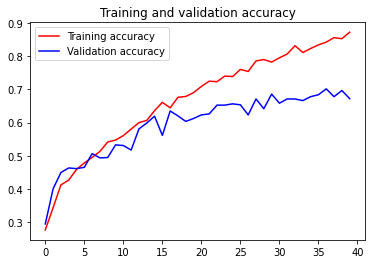

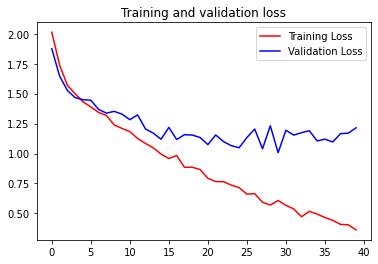

In [34]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Predicting the Model

Here we can input images to test our own image against the model. Currently our best model has 84.26% training accuracy and 70.17% validation accuracy. Not great, but still decent.


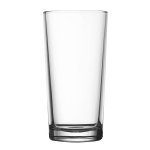

In [35]:
# Predict an image
image_path = '/content/glasstest.jpg'

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))

image_show = cv2.imread(image_path)
image_show = cv2.resize(image_show, (150,150), interpolation = cv2.INTER_AREA)

cv2_imshow(image_show)

[[5.11204184e-04 5.13644181e-06 9.96052504e-01 8.92732533e-06
  1.06038024e-04 3.30201350e-03 7.79171430e-08 1.40165021e-05
  6.34483266e-09]]
Predicted class = [2], predicted label = ['Glass']


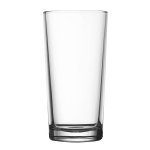

In [36]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)
# Convert single image to a batch.
input_arr = np.array([input_arr])  
# Normalize the image
input_arr = input_arr.astype('float32') / 255.

predictions = model.predict(input_arr)
print(predictions)
predicted_class = np.argmax(predictions, axis=-1)
predicted_label = labels[predicted_class]
print("Predicted class = {}, predicted label = {}".format(predicted_class, predicted_label))
cv2_imshow(image_show)

# Saving the Model

Lastly, we save our model in `.h5` format so that it can be used again later on without retraining the model since it takes quite a lot of time (~2 minutes per epoch with 40 epochs). We also convert the saved model into `.tflite` format so that it can be used in Mobile Development.

In [37]:
!mkdir -p "saved_model"
!mkdir -p "tflite_model"

In [45]:
# Saving the model
model.save('saved_model')
model.save('saved_model/model.h5')

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [46]:
# Saving the model in .tflite format
new_model= tf.saved_model.load("saved_model")
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
converter.optimizations = []
converter.allow_custom_ops=False
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("tflite_model/model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp989_wij0/assets


INFO:tensorflow:Assets written to: /tmp/tmp989_wij0/assets


13259632

In [47]:
# Upload to drive
shutil.copy("saved_model/model.h5","/content/drive/MyDrive/saved_model")
shutil.copy("tflite_model/model.tflite","/content/drive/MyDrive/tflite_model")
shutil.copy("model_weights/checkpoint","/content/drive/MyDrive/model_weights")
shutil.copy("model_weights/model_weights.data-00000-of-00001","/content/drive/MyDrive/model_weights")
shutil.copy("model_weights/model_weights.index","/content/drive/MyDrive/model_weights")

'/content/drive/MyDrive/model_weights/model_weights.index'